### Importing Libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# set all seed
def set_seed(seed=42):
    np.random.seed(seed)
seed = 0
set_seed(seed)

### Defining Important Functions

In [2]:
def plot_data(df, x_col, y_col, title, xlabel, ylabel, figsize=(15,5)):
    plt.figure(figsize=figsize)
    plt.plot(df[x_col], df[y_col])
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid()
    plt.show()

def calculate_nse(observed, predicted):
    """Calculate Nash-Sutcliffe Efficiency (NSE)"""
    numerator = np.sum((observed - predicted) ** 2)
    denominator = np.sum((observed - np.mean(observed)) ** 2)
    nse = 1 - (numerator / denominator)
    return nse

def calculate_rmse(observed, predicted):
    """Calculate Root Mean Square Error (RMSE)"""
    rmse = np.sqrt(np.mean((observed - predicted) ** 2))
    return rmse


def calculate_mae(observed, predicted):
    """Calculate Mean Absolute Error (MAE)"""
    mae = np.mean(np.abs(observed - predicted))
    return mae

def calculate_physical_consistency(observed, predicted):
    """Check if predicted values are realistic (e.g., non-negative)"""
    consistency = np.all(predicted >= 0)
    return consistency

# Calculate performance metrics
def calc_metrics(observed, predicted):
    rmse = calculate_rmse(observed, predicted)
    mae = calculate_mae(observed, predicted)
    nse = calculate_nse(observed, predicted)
    physical_consistency = calculate_physical_consistency(observed, predicted)
    print(f"RMSE = {rmse:.8f}, MAE = {mae:.8f}, NSE = {nse:.8f}, Physical Consistency = {physical_consistency}")
    return rmse, mae, nse, physical_consistency

def plot_ground_truth_vs_prediction(df, y_pred, title_hourly, title_daily, ylabel, figsize=(15, 5)):
    """Plot ground truth vs predictions for hourly and daily data."""
    # Plot hourly predictions
    plt.figure(figsize=figsize)
    plt.plot(df['valid_time'], df['tp'], label='Ground Truth', color='blue')
    plt.plot(df['valid_time'], y_pred[:, 0], label='Predicted Hourly', color='orange')
    plt.title(title_hourly)
    plt.xlabel('Date')
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid()
    plt.show()

    # Plot daily predictions
    daily_pred_df = pd.merge(df[['valid_time']], pd.DataFrame(y_pred, columns=target), left_index=True, right_index=True)
    daily_pred_df = daily_pred_df[daily_pred_df['valid_time'].dt.hour == 0]
    plt.figure(figsize=figsize)
    plt.plot(df[df['valid_time'].dt.hour == 0]['valid_time'], df[df['valid_time'].dt.hour == 0]['tp'], label='Ground Truth', color='blue')
    plt.plot(daily_pred_df['valid_time'], daily_pred_df['tp'], label='Predicted Daily', color='orange')
    plt.title(title_daily)
    plt.xlabel('Date')
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid()
    plt.show()

### Loading Data

In [9]:
data_dir = '/content/'

train_df = pd.read_csv(os.path.join(data_dir, 'train_data.csv'))
train_df['valid_time'] = pd.to_datetime(train_df['valid_time'])
print("Number of rows in training data:", len(train_df))
# format: # year,month,day,hour,yearly_mean,yearly_max,yearly_min,yearly_std,yearly_var,monthly_mean,monthly_max,monthly_min,monthly_std,monthly_var,daily_mean,daily_max,daily_min,daily_std,daily_var

val_df = pd.read_csv(os.path.join(data_dir, 'val_data.csv'))
val_df['valid_time'] = pd.to_datetime(val_df['valid_time'])
print("Number of rows in validation data:", len(val_df))

test_df = pd.read_csv(os.path.join(data_dir, 'test_data.csv'))
test_df['valid_time'] = pd.to_datetime(test_df['valid_time'])
print("Number of rows in test data:", len(test_df))


Number of rows in training data: 87672
Number of rows in validation data: 17520
Number of rows in test data: 17544


In [10]:
def add_cycle_features(df):
    """Add cyclic features for month and year to the dataframe."""
    df['month_sin'] = np.sin(2 * np.pi * df['valid_time'].dt.month / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['valid_time'].dt.month / 12)
    df['year_sin'] = np.sin(2 * np.pi * df['valid_time'].dt.year / 12)
    df['year_cos'] = np.cos(2 * np.pi * df['valid_time'].dt.year / 12)
    return df

# Apply the function to train, validation, and test datasets
train_df = add_cycle_features(train_df)
val_df = add_cycle_features(val_df)
test_df = add_cycle_features(test_df)

In [11]:
features = ['year', 'month', 'day', 'hour',
            'yearly_mean', 'yearly_max', 'yearly_min', 'yearly_std', 'yearly_var',
            'monthly_mean', 'monthly_max', 'monthly_min', 'monthly_std', 'monthly_var',
            'month_sin', 'month_cos', 'year_sin', 'year_cos']
target = ['tp', 'daily_mean']

In [12]:
# Prepare feature matrices and target vectors for each set
X_train = train_df[features]
y_train = train_df[target]
X_val = val_df[features]
y_val = val_df[target]
X_test = test_df[features]
y_test = test_df[target]

## Random Forest Regressor

In [13]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [14]:
# Train a Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=seed)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=0)

(730, 3)
Validation on Hourly Predictions: 
RMSE = 0.00041322, MAE = 0.00024353, NSE = 0.03890963, Physical Consistency = True
Validation on Daily Predictions: 
RMSE = 0.00043679, MAE = 0.00024686, NSE = 0.04266603, Physical Consistency = True


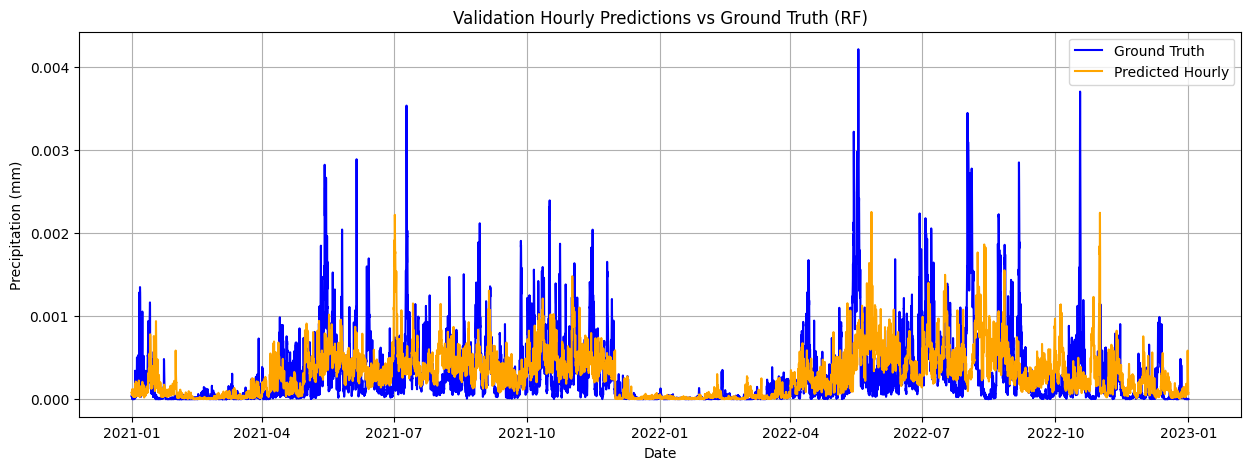

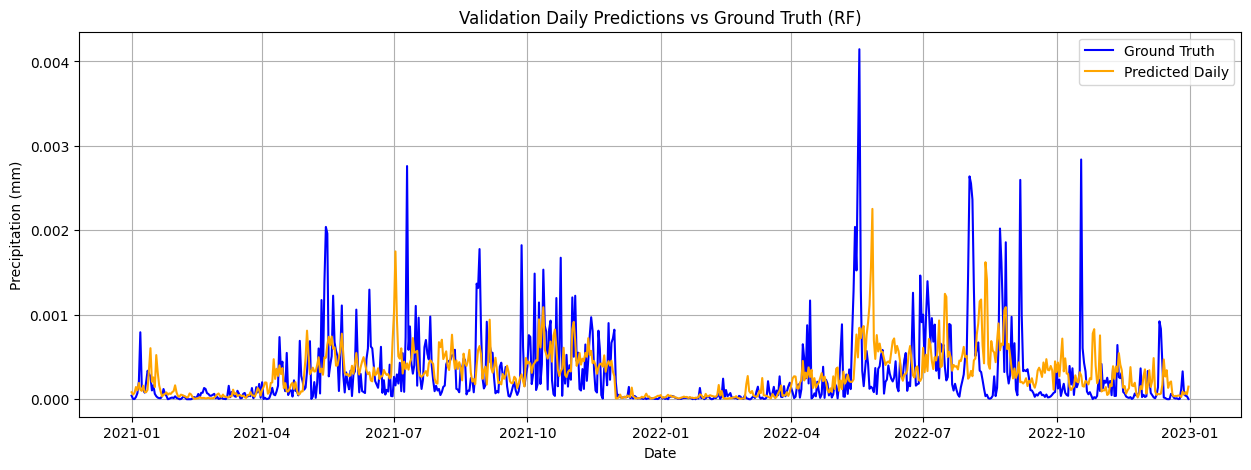

In [15]:
# Predict on validation
y_val_pred = rf_model.predict(X_val)

daily_pred_df_val = pd.merge(val_df[['valid_time']], pd.DataFrame(y_val_pred, columns=target), left_index=True, right_index=True)
daily_pred_df_val = daily_pred_df_val[daily_pred_df_val['valid_time'].dt.hour == 0]
print(daily_pred_df_val.shape)

print(f"Validation on Hourly Predictions: ")
rmse_val, mae_val, nse_val, _ = calc_metrics(val_df['tp'], y_val_pred[:, 0])
print(f"Validation on Daily Predictions: ")
rmse_val, mae_val, nse_val, _ = calc_metrics(val_df[val_df['valid_time'].dt.hour == 0]['tp'], daily_pred_df_val['tp'])

plot_ground_truth_vs_prediction(val_df, y_val_pred,
                               title_hourly='Validation Hourly Predictions vs Ground Truth (RF)',
                               title_daily='Validation Daily Predictions vs Ground Truth (RF)',
                               ylabel='Precipitation (mm)')

(731, 3)
Test on Hourly Predictions: 
RMSE = 0.00037678, MAE = 0.00021458, NSE = 0.19428169, Physical Consistency = True
Test on Daily Predictions: 
RMSE = 0.00041219, MAE = 0.00021953, NSE = 0.18585541, Physical Consistency = True


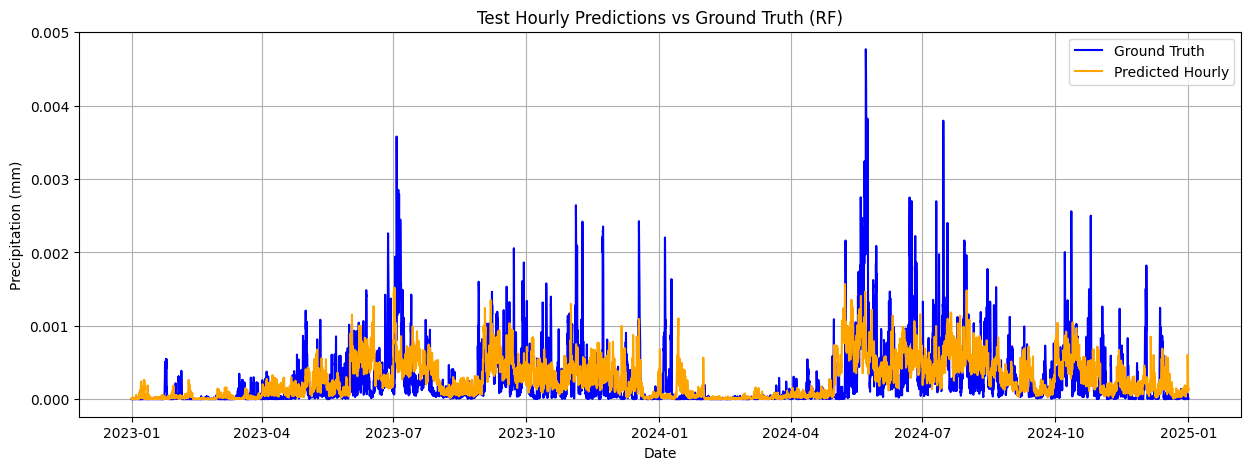

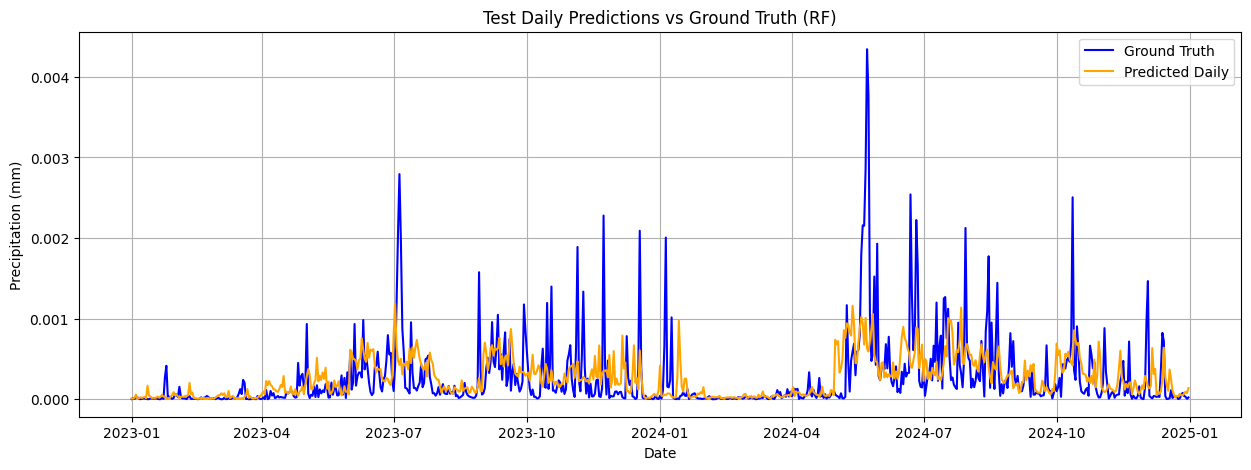

In [16]:
# Predict on test
y_test_pred = rf_model.predict(X_test)

daily_pred_df_test = pd.merge(test_df[['valid_time']], pd.DataFrame(y_test_pred, columns=target), left_index=True, right_index=True)
daily_pred_df_test = daily_pred_df_test[daily_pred_df_test['valid_time'].dt.hour == 0]
print(daily_pred_df_test.shape)
print(f"Test on Hourly Predictions: ")
rmse_test, mae_test, nse_test, _ = calc_metrics(test_df['tp'], y_test_pred[:, 0])
print(f"Test on Daily Predictions: ")
rmse_test, mae_test, nse_test, _ = calc_metrics(test_df[test_df['valid_time'].dt.hour == 0]['tp'], daily_pred_df_test['tp'])

# plot ground truth and predictions
plot_ground_truth_vs_prediction(test_df, y_test_pred,
                               title_hourly='Test Hourly Predictions vs Ground Truth (RF)',
                               title_daily='Test Daily Predictions vs Ground Truth (RF)',
                               ylabel='Precipitation (mm)')

In [17]:
# save model
import joblib
model_path = 'rf_model.pkl'
joblib.dump(rf_model, model_path)
print(f"Model saved to {model_path}")

Model saved to rf_model.pkl


## XGBoost Regressor


In [18]:
# XGBoost
from xgboost import XGBRegressor

xgb_model = XGBRegressor(n_estimators=100, random_state=seed)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=0, ...)

(730, 3)
Validation on Hourly Predictions: 
RMSE = 0.00038832, MAE = 0.00022532, NSE = 0.15127620, Physical Consistency = False
Validation on Daily Predictions: 
RMSE = 0.00041219, MAE = 0.00022483, NSE = 0.14746596, Physical Consistency = True


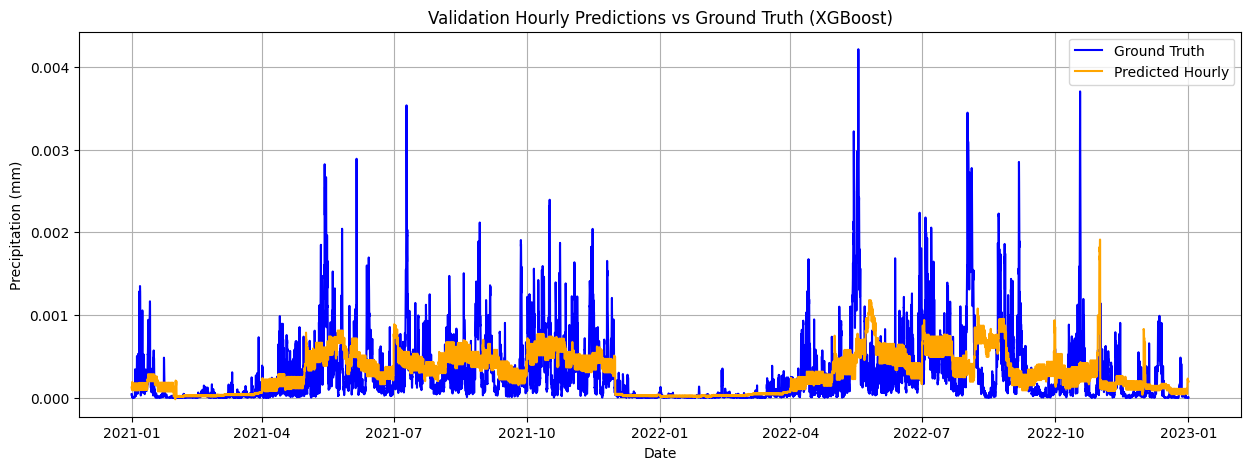

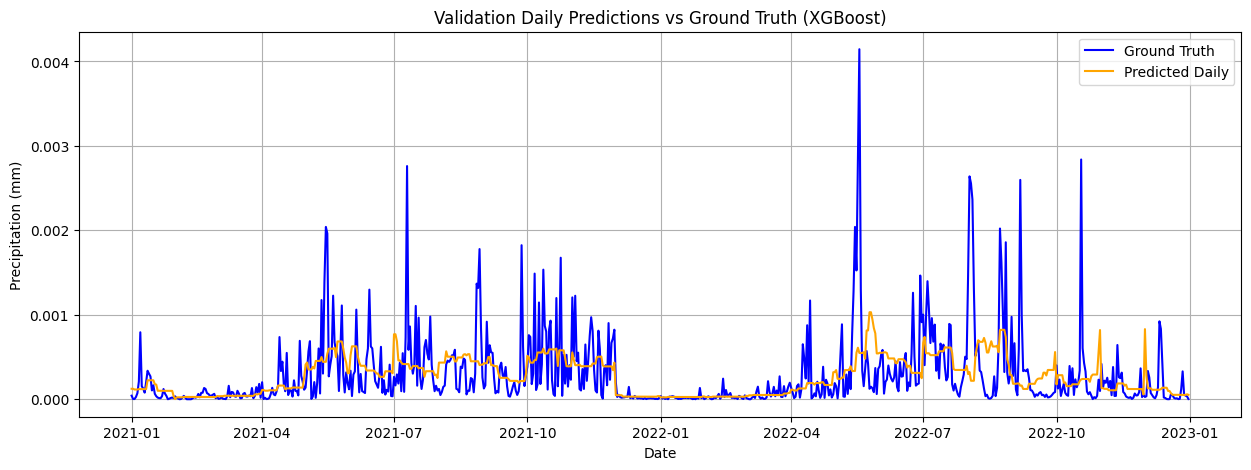

In [19]:
# Predict on validation
y_val_pred_xgb = xgb_model.predict(X_val)
daily_pred_df_val_xgb = pd.merge(val_df[['valid_time']], pd.DataFrame(y_val_pred_xgb, columns=target), left_index=True, right_index=True)
daily_pred_df_val_xgb = daily_pred_df_val_xgb[daily_pred_df_val_xgb['valid_time'].dt.hour == 0]
print(daily_pred_df_val_xgb.shape)

print(f"Validation on Hourly Predictions: ")
rmse_val_xgb, mae_val_xgb, nse_val_xgb, _ = calc_metrics(val_df['tp'], y_val_pred_xgb[:, 0])
print(f"Validation on Daily Predictions: ")
rmse_val_xgb, mae_val_xgb, nse_val_xgb, _ = calc_metrics(val_df[val_df['valid_time'].dt.hour == 0]['tp'], daily_pred_df_val_xgb['tp'])
# plot ground truth and predictions
plot_ground_truth_vs_prediction(val_df, y_val_pred_xgb,
                               title_hourly='Validation Hourly Predictions vs Ground Truth (XGBoost)',
                               title_daily='Validation Daily Predictions vs Ground Truth (XGBoost)',
                               ylabel='Precipitation (mm)')




(731, 3)
Test on Hourly Predictions: 
RMSE = 0.00036710, MAE = 0.00020150, NSE = 0.23514476, Physical Consistency = True
Test on Daily Predictions: 
RMSE = 0.00040691, MAE = 0.00020328, NSE = 0.20658760, Physical Consistency = True


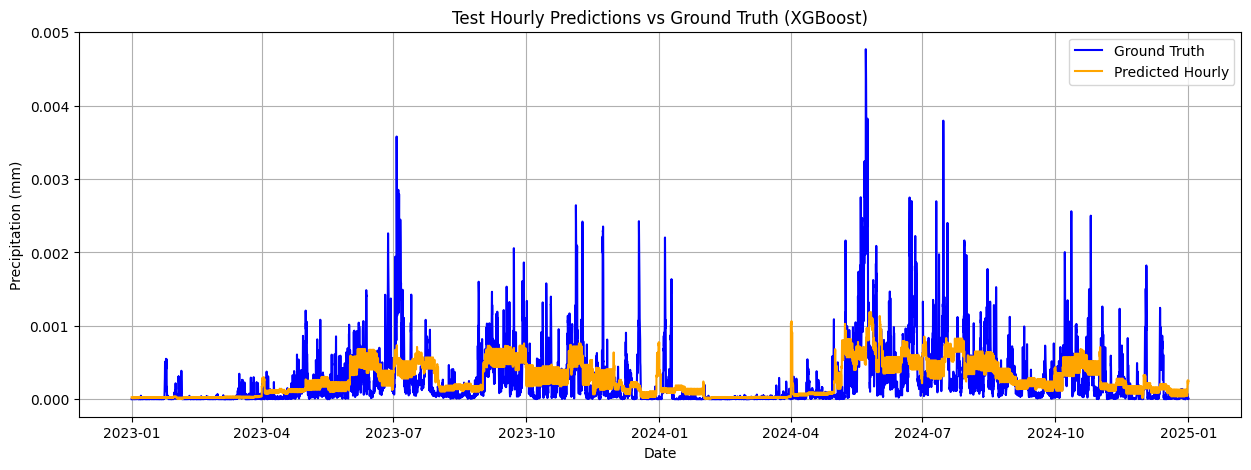

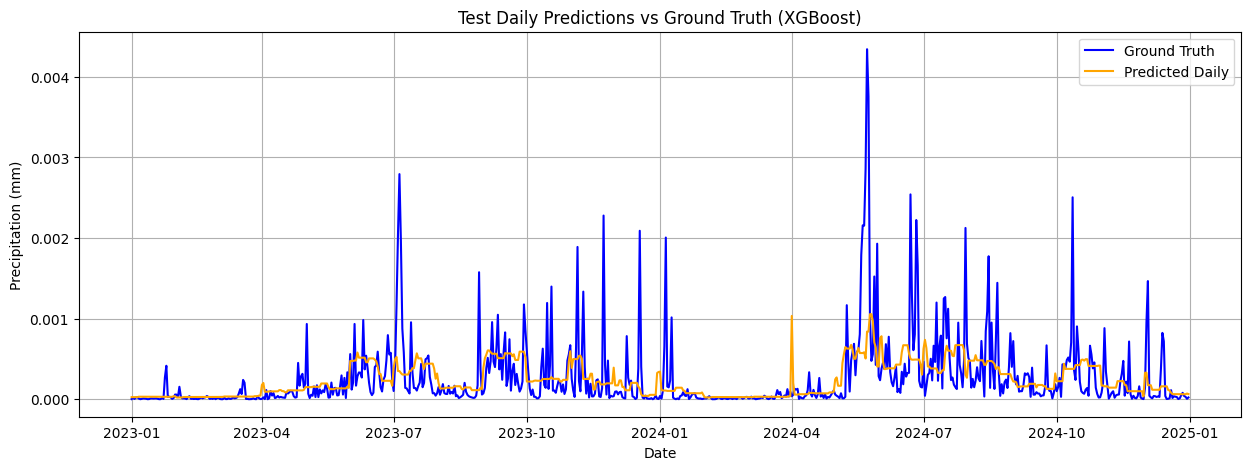

In [20]:
# Predict on test
y_test_pred_xgb = xgb_model.predict(X_test)
daily_pred_df_test_xgb = pd.merge(test_df[['valid_time']], pd.DataFrame(y_test_pred_xgb, columns=target), left_index=True, right_index=True)
daily_pred_df_test_xgb = daily_pred_df_test_xgb[daily_pred_df_test_xgb['valid_time'].dt.hour == 0]
print(daily_pred_df_test_xgb.shape)
print(f"Test on Hourly Predictions: ")
rmse_test_xgb, mae_test_xgb, nse_test_xgb, _ = calc_metrics(test_df['tp'], y_test_pred_xgb[:, 0])
print(f"Test on Daily Predictions: ")
rmse_test_xgb, mae_test_xgb, nse_test_xgb, _ = calc_metrics(test_df[test_df['valid_time'].dt.hour == 0]['tp'], daily_pred_df_test_xgb['tp'])
# plot ground truth and predictions
plot_ground_truth_vs_prediction(test_df, y_test_pred_xgb,
                               title_hourly='Test Hourly Predictions vs Ground Truth (XGBoost)',
                               title_daily='Test Daily Predictions vs Ground Truth (XGBoost)',
                               ylabel='Precipitation (mm)')



In [21]:
# save model
model_path_xgb = 'xgb_model.pkl'
joblib.dump(xgb_model, model_path_xgb)
print(f"Model saved to {model_path_xgb}")


Model saved to xgb_model.pkl
